In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NACCNINR', 'INRELTO', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'NACCSTYR', 'NACCTIYR', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'COMPORT', 'CDRLANG', 'NPIQINF', 'DEL', 'DELSEV', 'HALL', 'HALLSEV', 'AGIT', 'AGITSEV', 'DEPD', 'DEPDSEV', 'ANX', 'ANXSEV', 'ELAT', 'ELATSEV', 'APA', 'APASEV', 'DISN', 'DISNSEV', 'IRR', 'IRRSEV', 'MOT', 'MOTSEV', 'NITE', 'NITESEV', 'APP', 'APPSEV', 'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES', 'TRAVEL', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGFLUC', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN'

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,0,2,3,10,1,0,3,0,2,2,...,1,1,1,1,0,0,41,4,305,False
1,1,1,9,35,1,0,3,0,2,2,...,1,1,1,0,0,0,15,33,97,True
2,0,1,7,20,1,0,3,0,2,2,...,0,1,1,0,0,0,26,2,0,False
3,1,0,6,27,0,0,3,0,2,2,...,1,1,1,0,0,0,19,80,0,False
4,0,2,4,20,0,0,3,0,2,2,...,0,1,1,0,0,0,31,43,148,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,0,0,4,40,0,0,3,0,2,2,...,0,1,1,1,0,0,11,36,262,False
427,0,1,4,43,1,0,3,0,2,2,...,1,1,1,0,0,0,9,78,132,False
428,1,1,6,13,1,0,3,0,1,2,...,1,1,1,0,0,0,39,3,31,True
429,2,1,8,40,0,0,3,0,2,2,...,1,0,1,0,0,0,10,12,0,False


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

50.12% samples are right censored in whole data.


In [6]:
Events

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True,  True, False,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
        True,  True,

In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=15
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 454.38


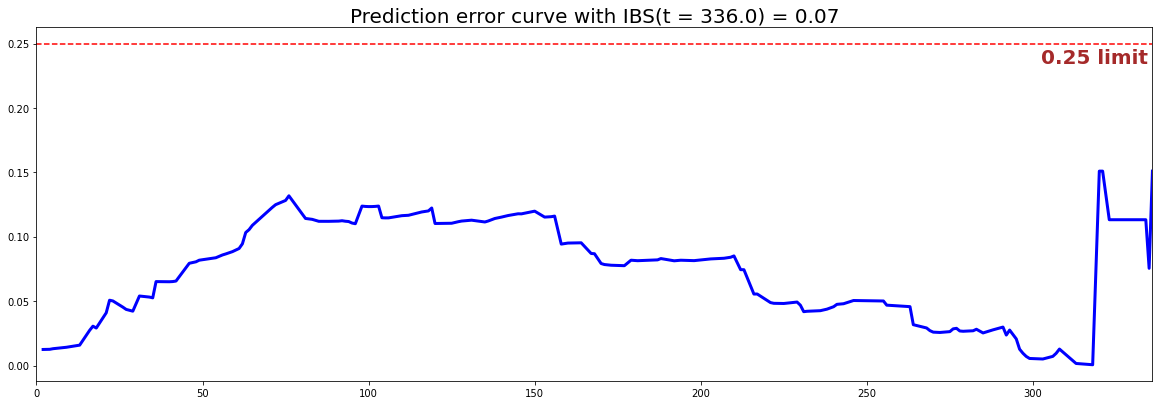

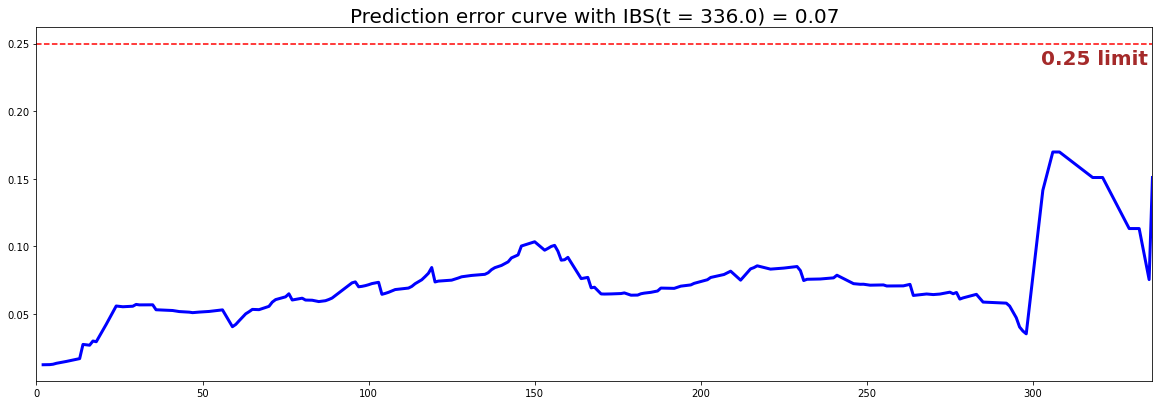

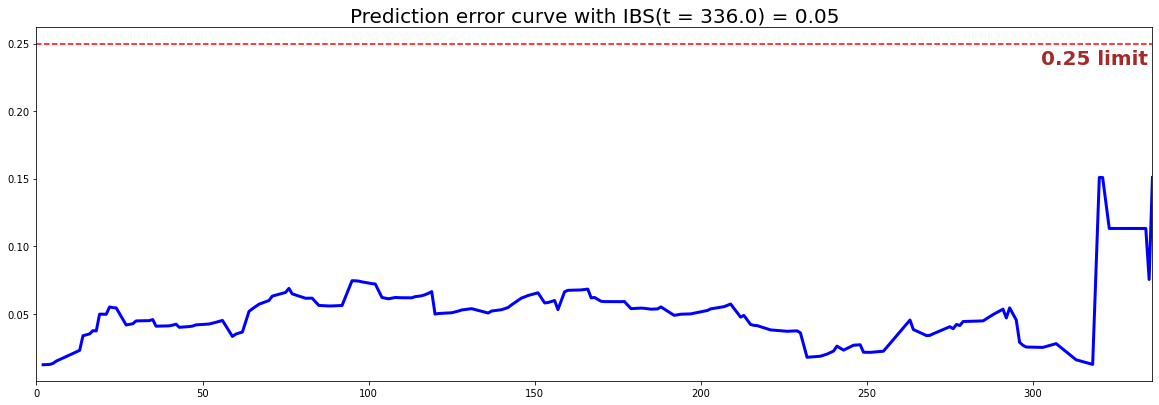

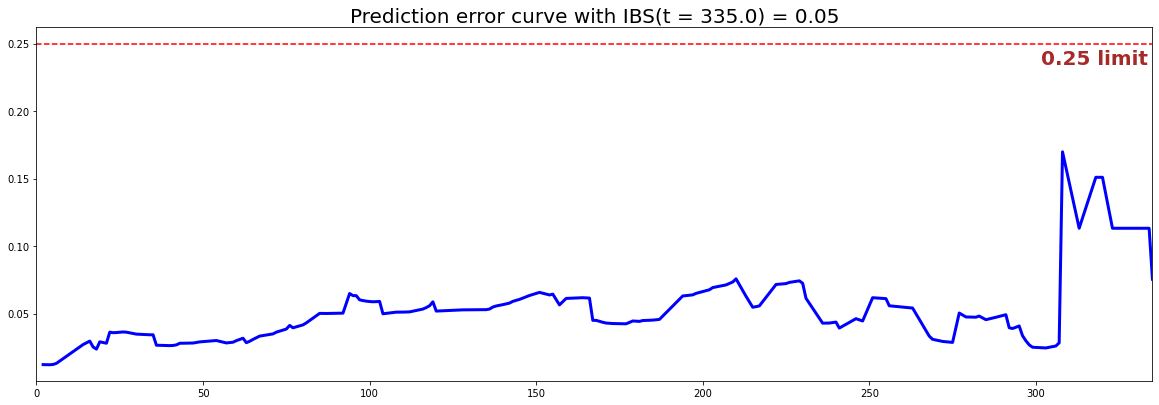

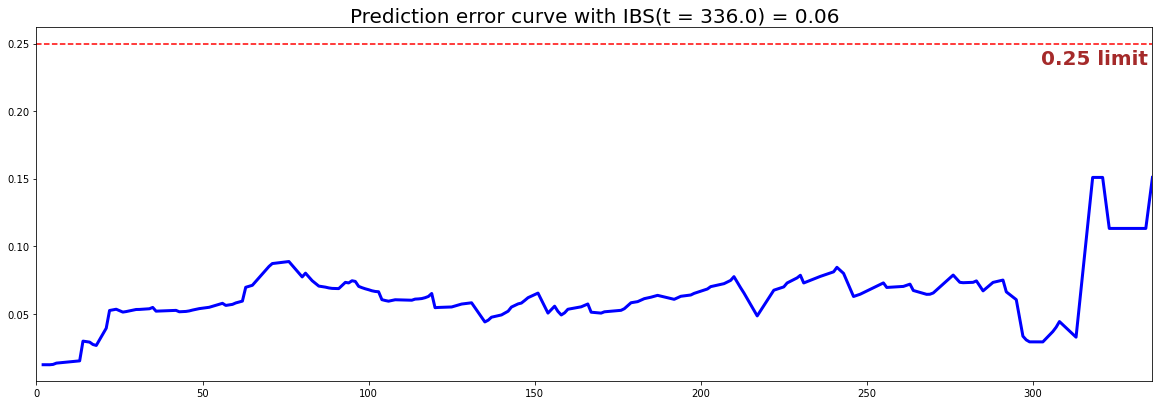

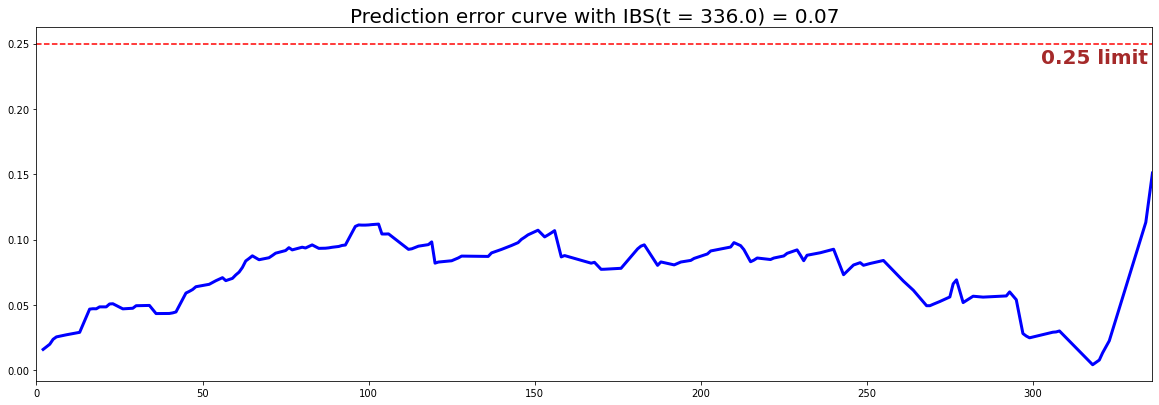

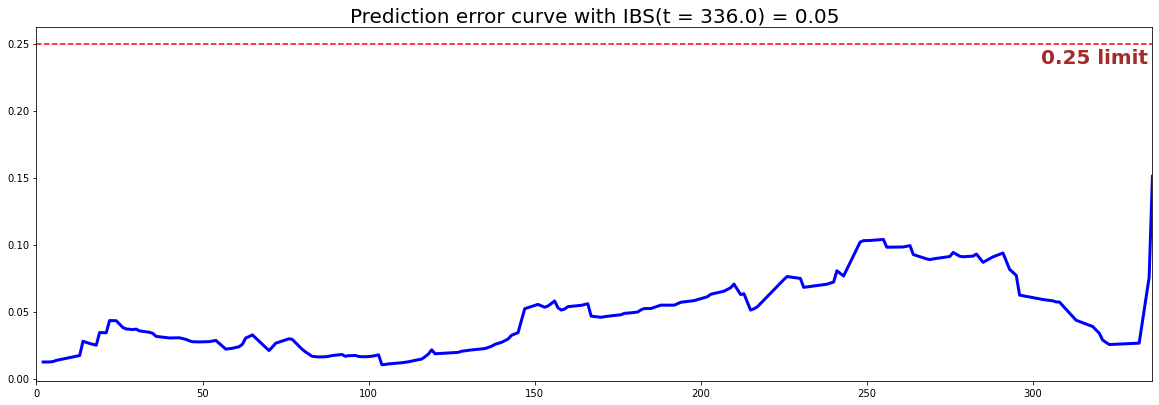

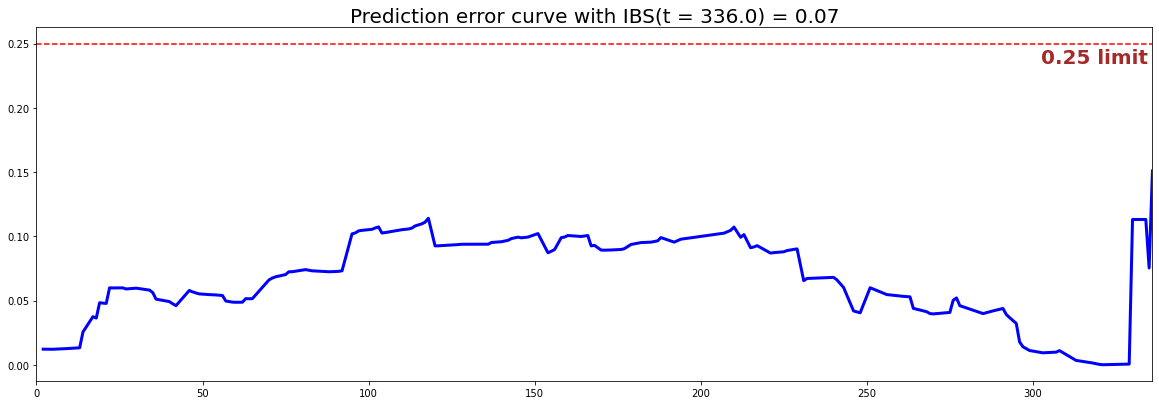

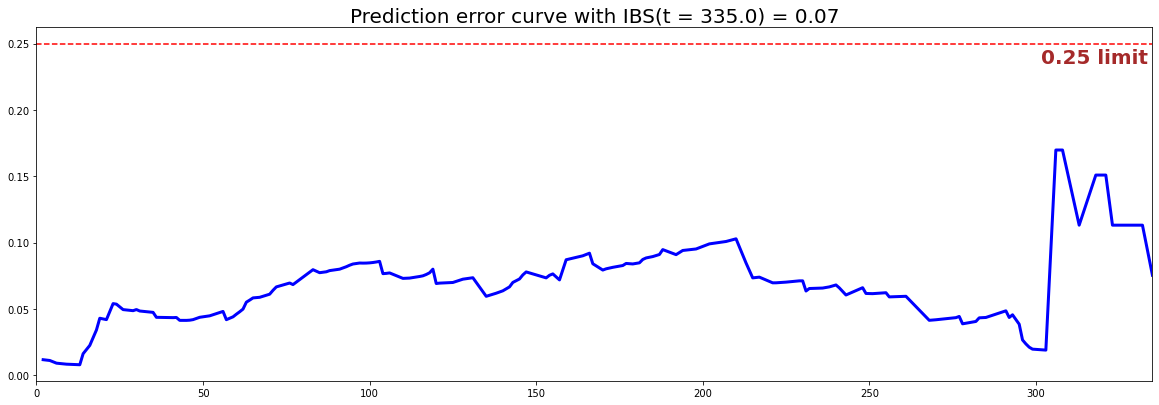

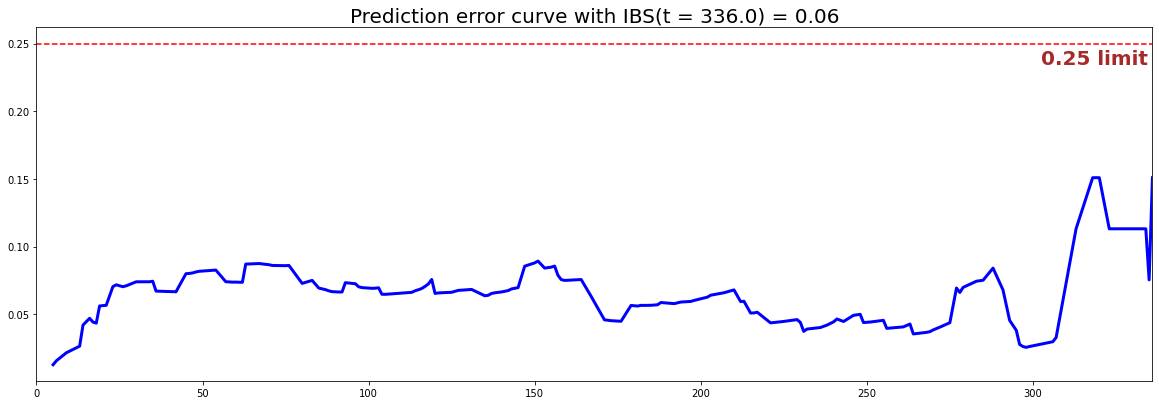

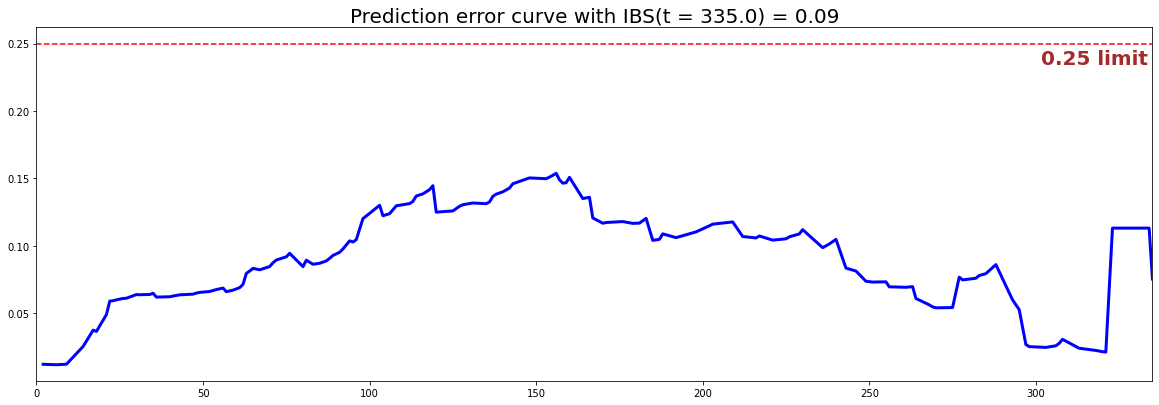

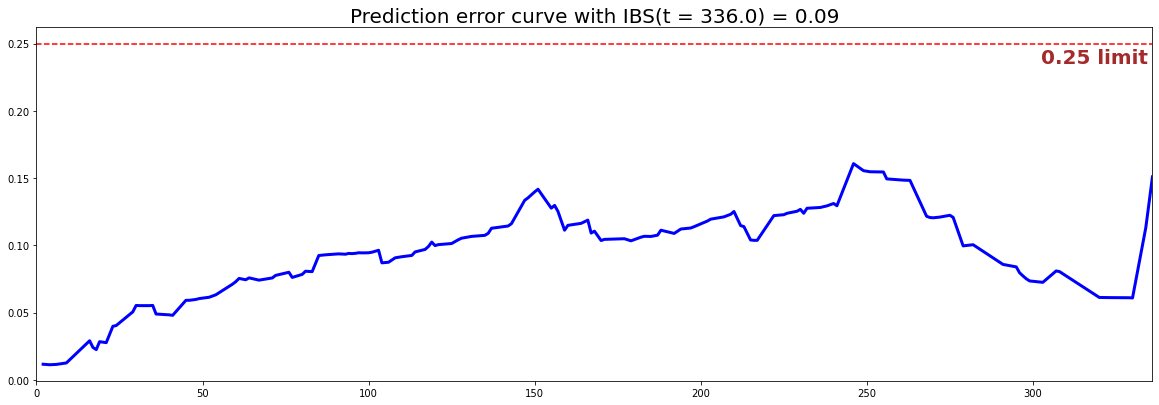

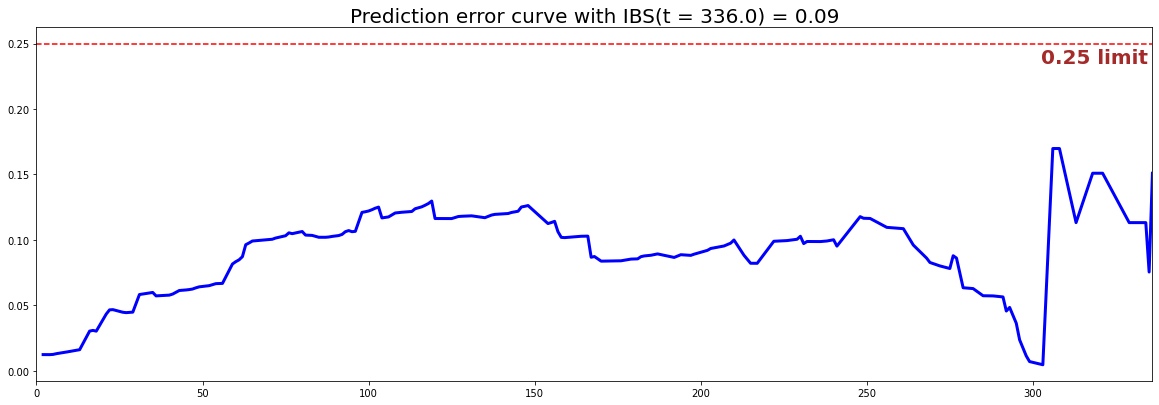

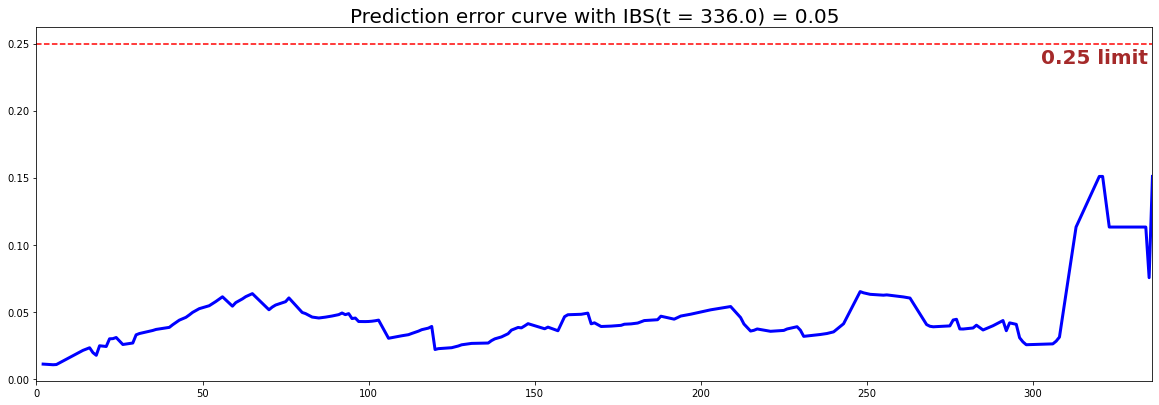

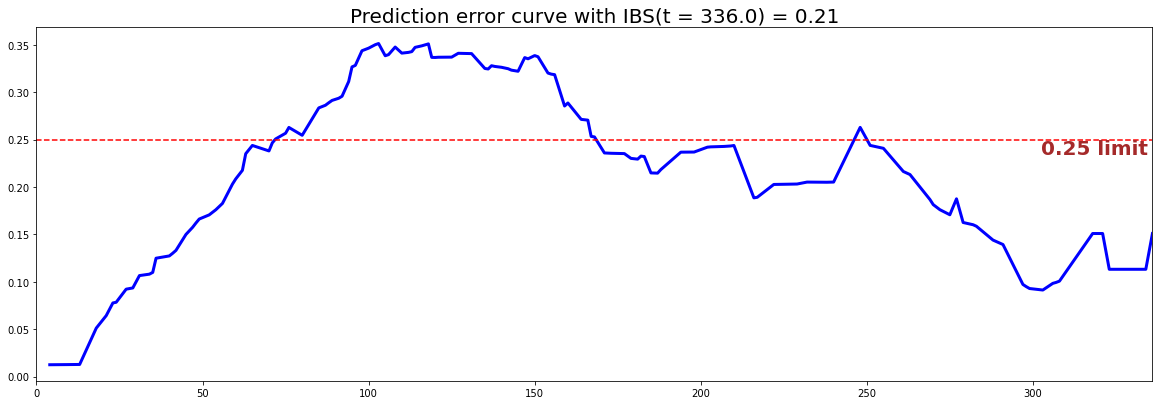

In [8]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [9]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.8967548346006541, 0.8932755732230357, 0.933121885217894, 0.9300537736767149, 0.899508419076157, 0.8802235144175458, 0.9152023282768676, 0.8947671665385539, 0.9077854016581068, 0.9092190663963982, 0.8604329375126452, 0.8417454515105174, 0.8604529618006526, 0.9462008046256513, 0.6793929259906137]
0.883209136301467
0.061072414730082764
[0.0724191358870964, 0.07336697149381051, 0.04920040575649795, 0.052833542429434985, 0.06315543807026641, 0.07250577562055256, 0.04715391316230753, 0.0663892715562568, 0.06892409044120411, 0.06423084692791287, 0.08923912235743235, 0.09382391929476232, 0.09060482096779188, 0.046328345265568505, 0.2088322549033038]
0.07726719027561327
0.038098023415080055


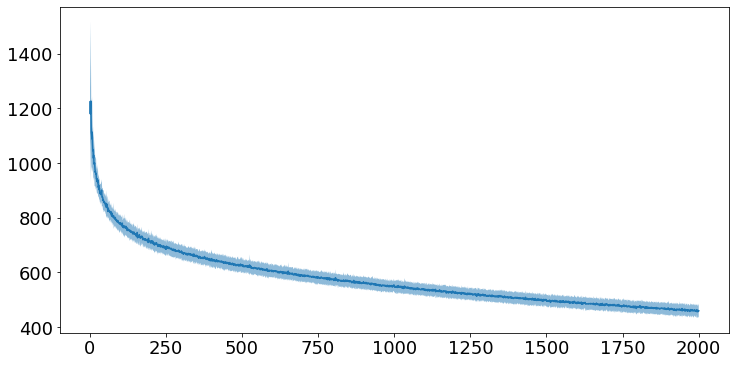

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

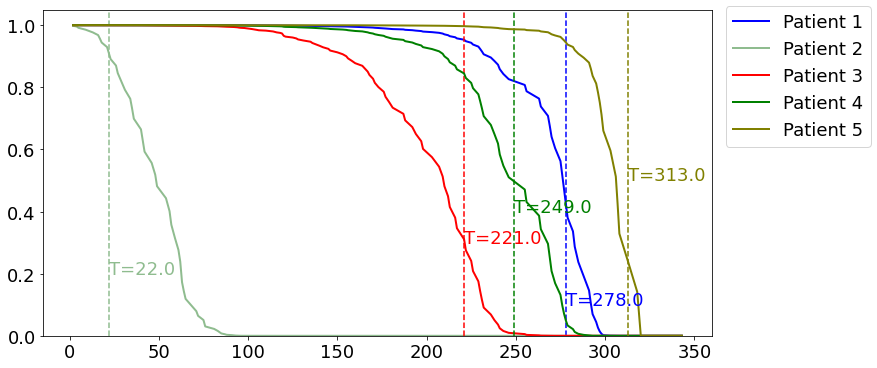

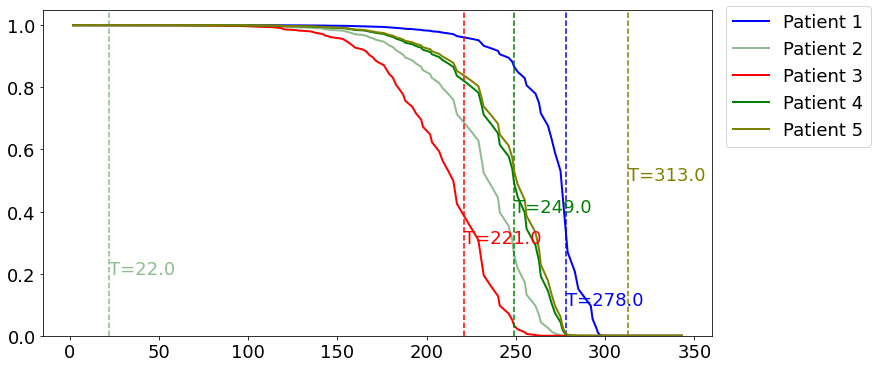

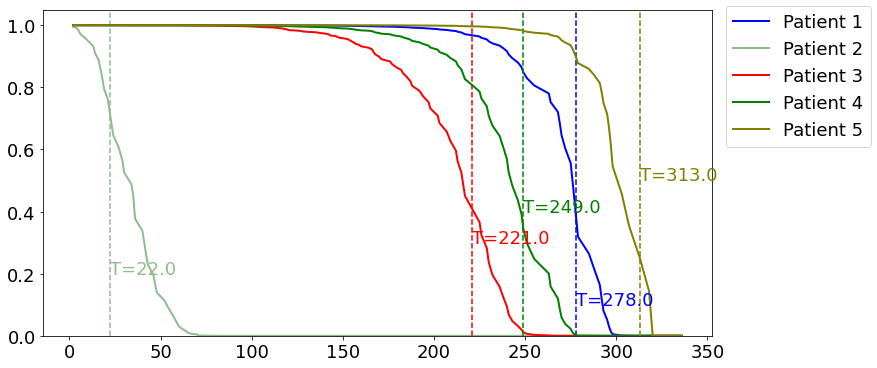

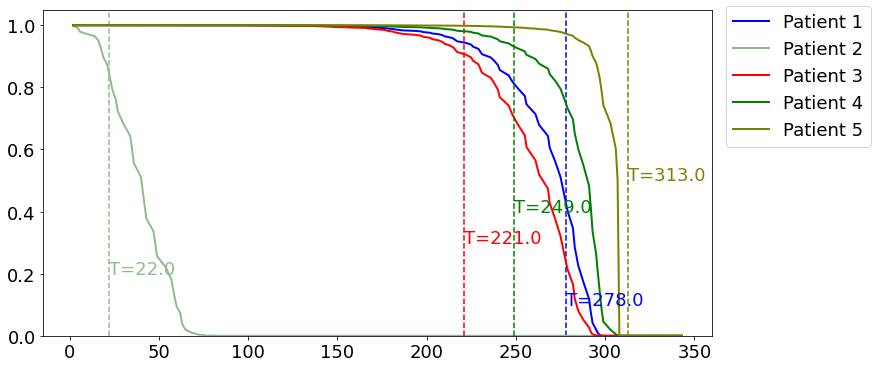

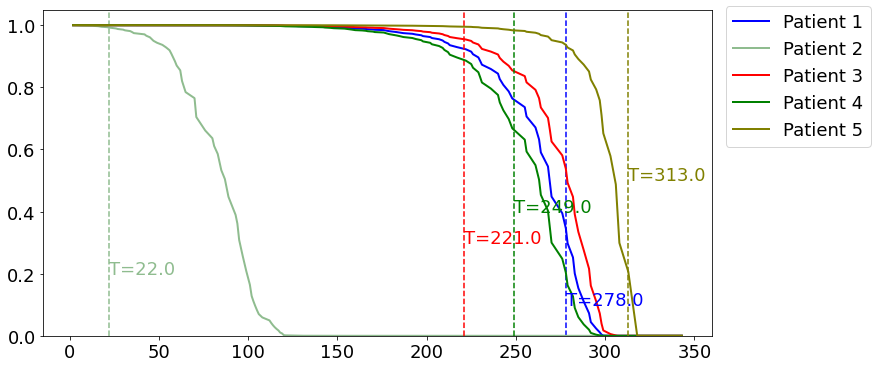

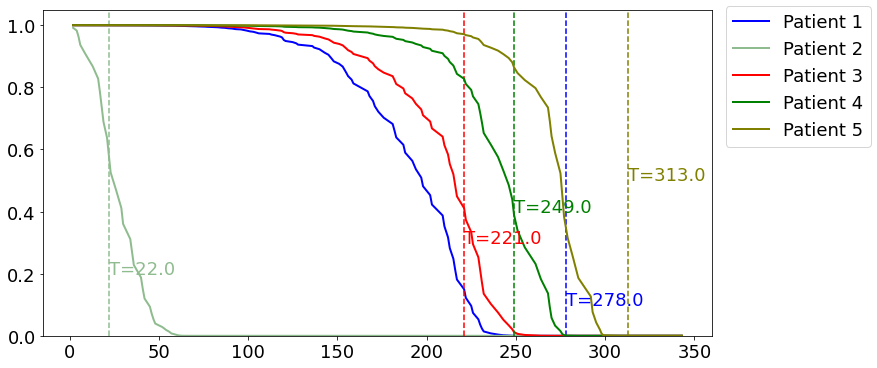

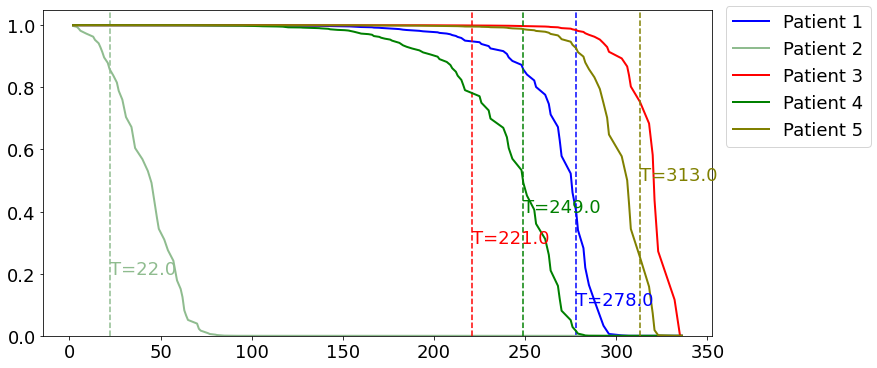

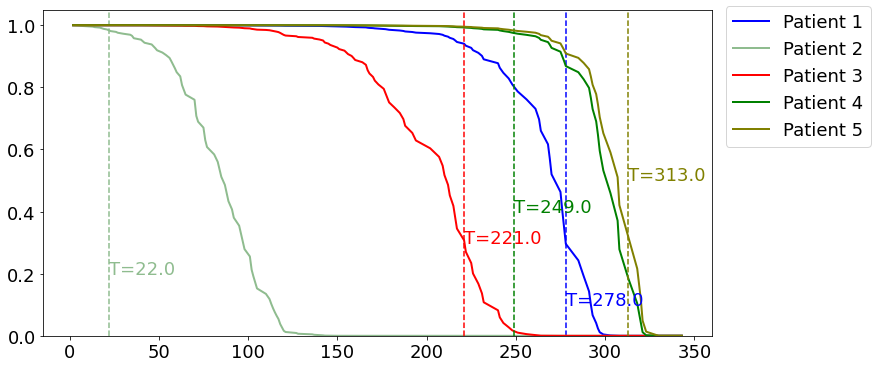

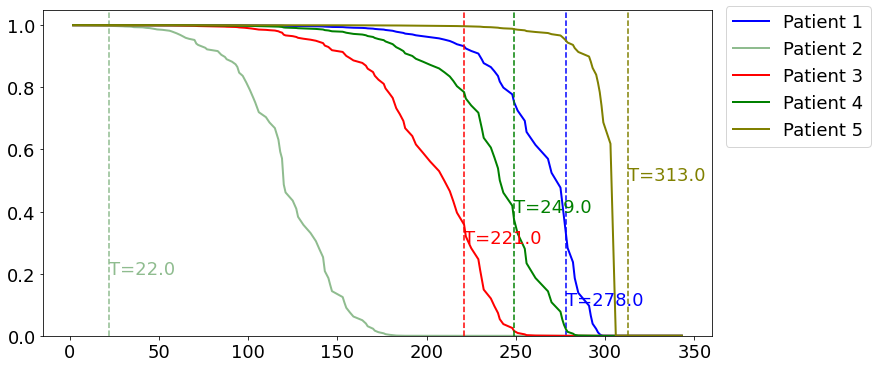

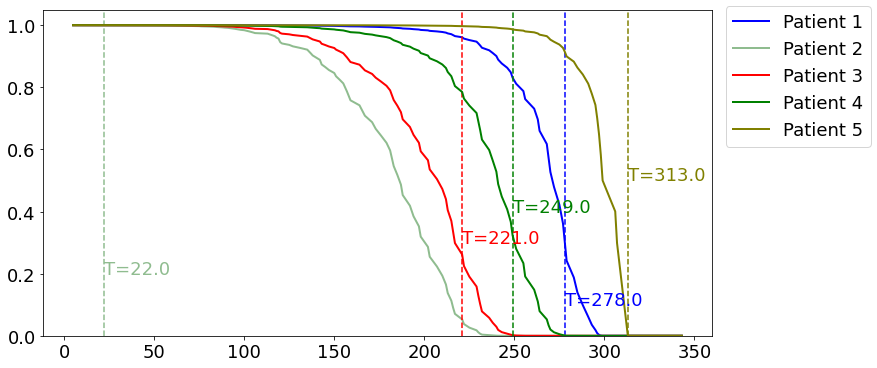

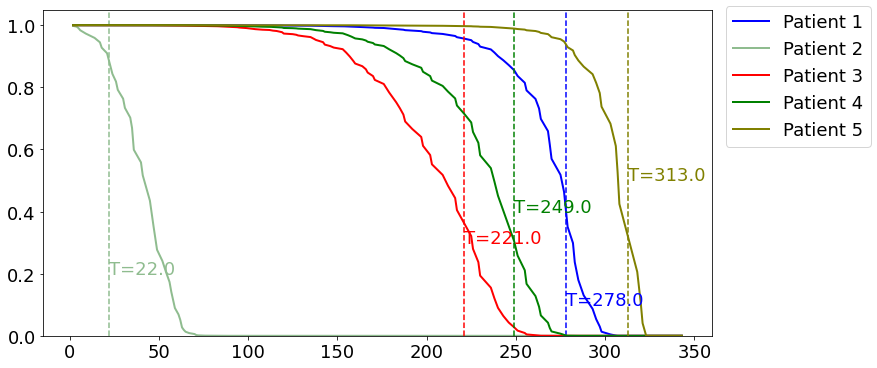

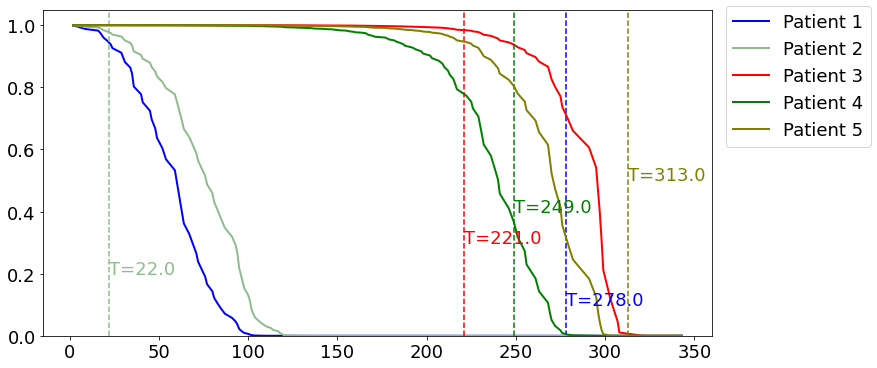

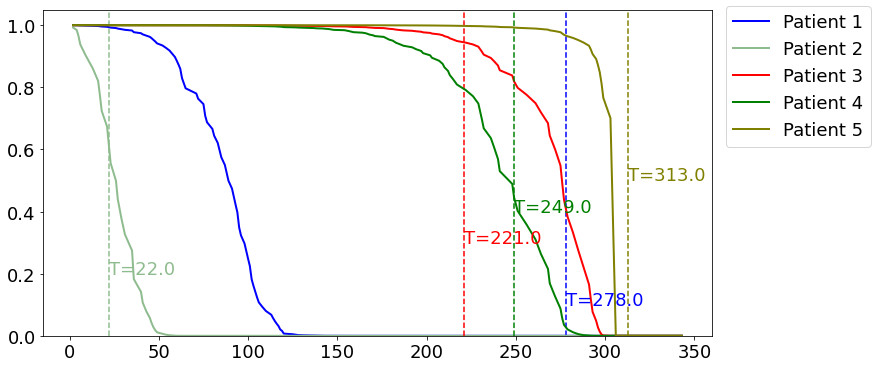

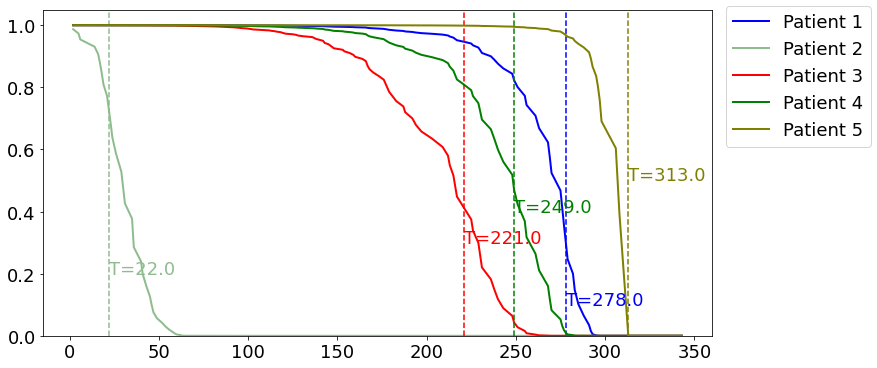

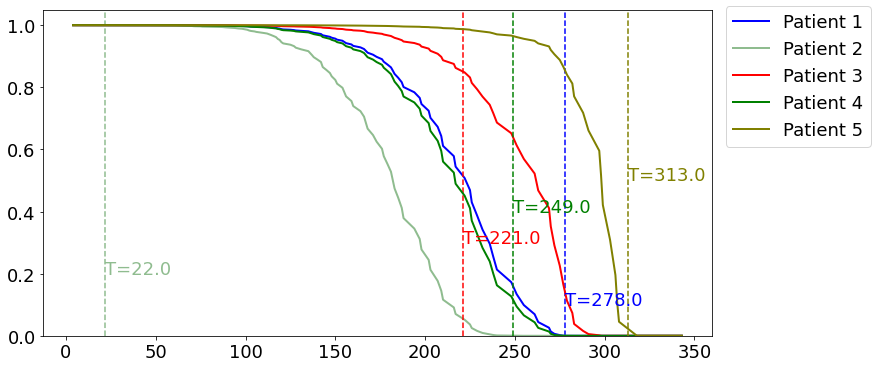

In [11]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

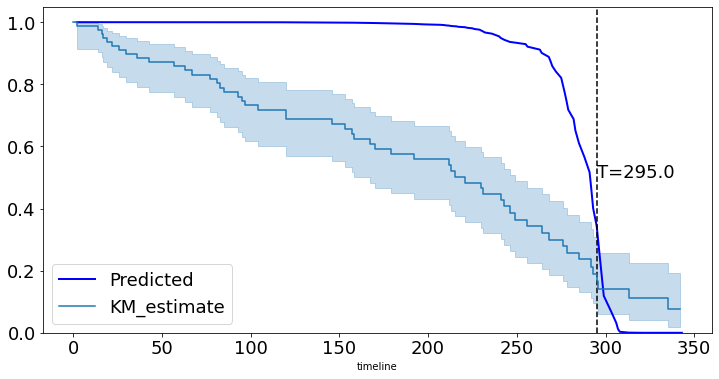

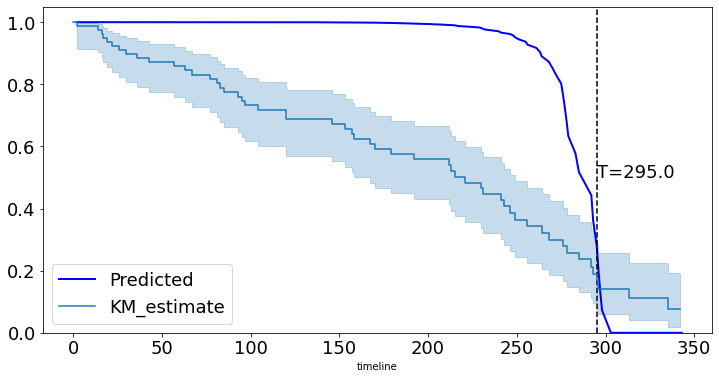

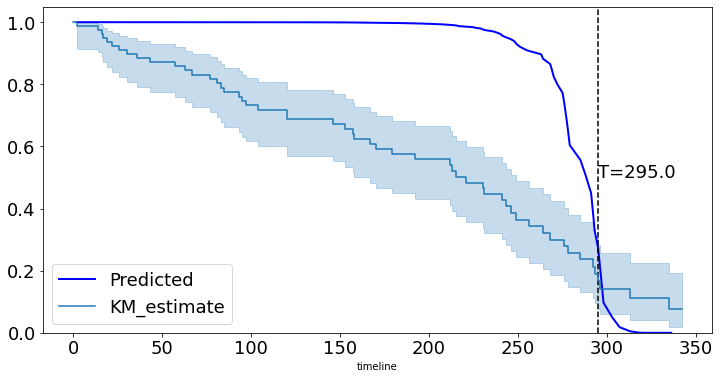

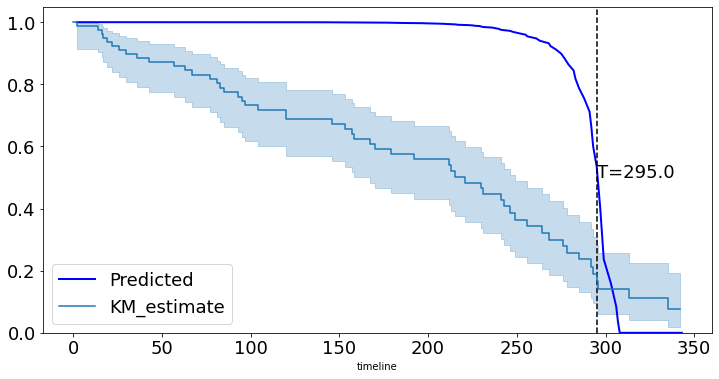

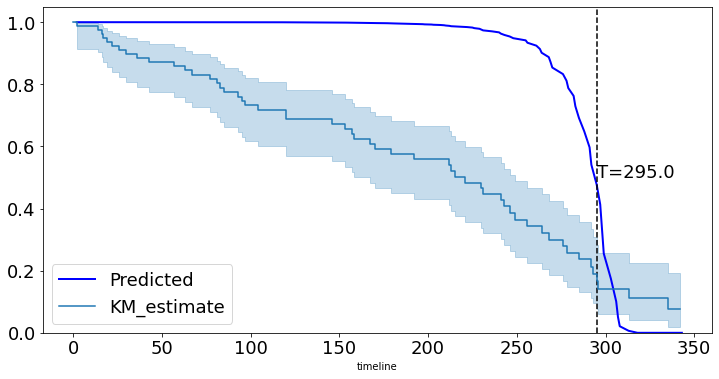

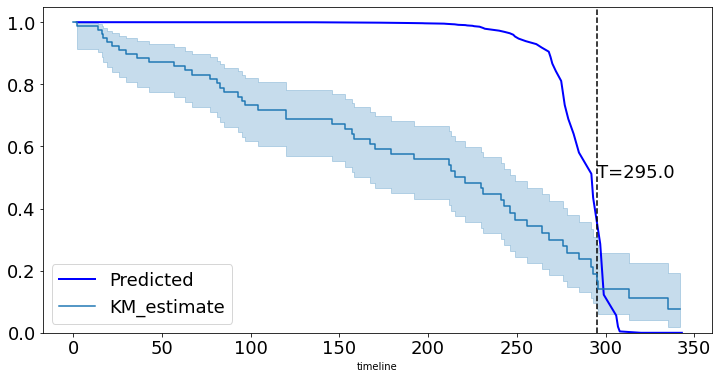

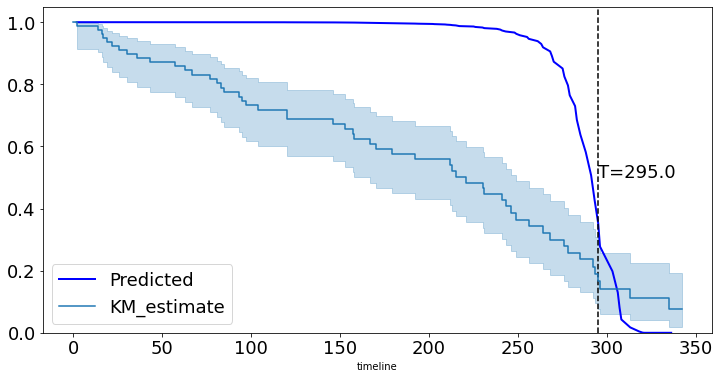

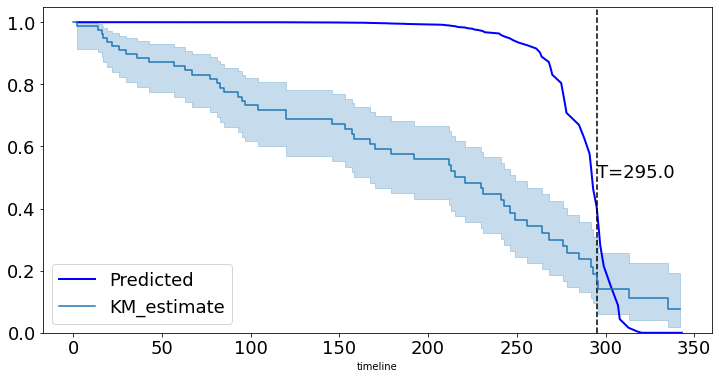

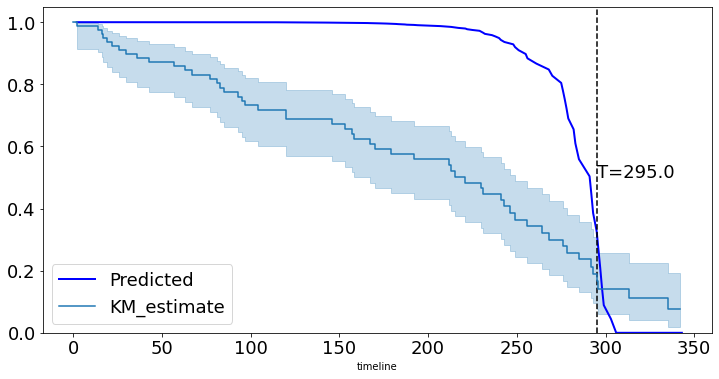

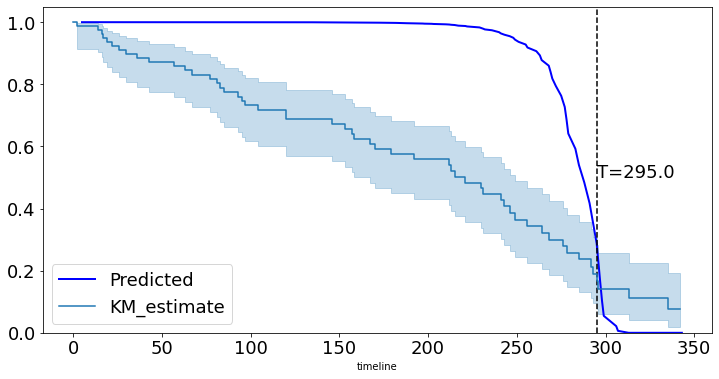

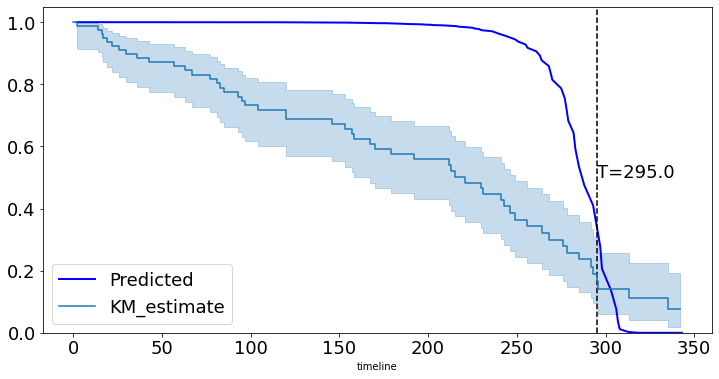

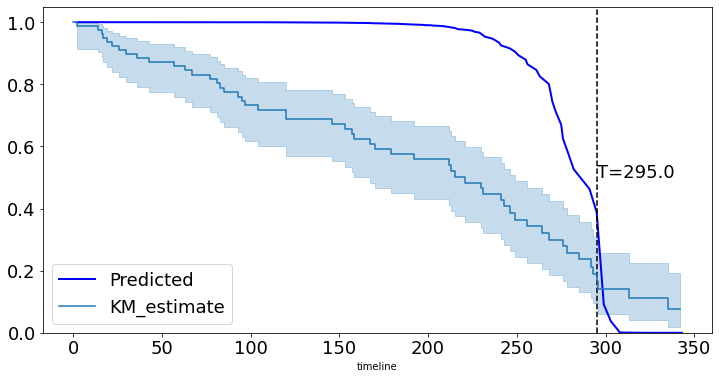

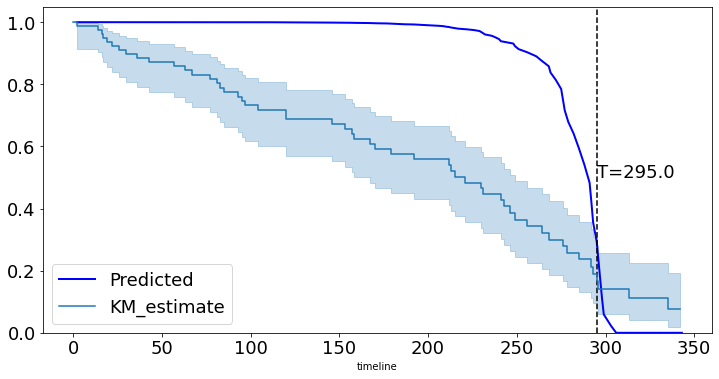

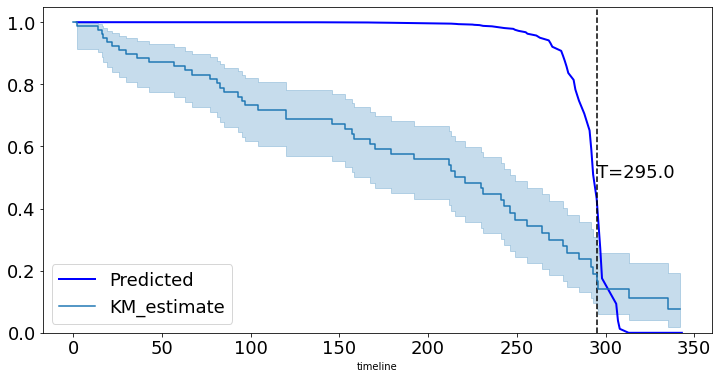

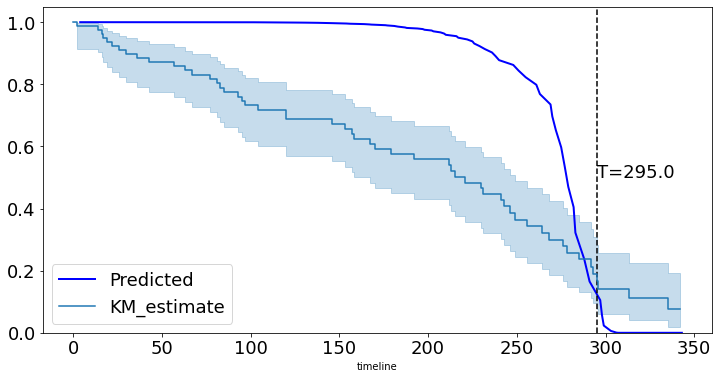

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [13]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

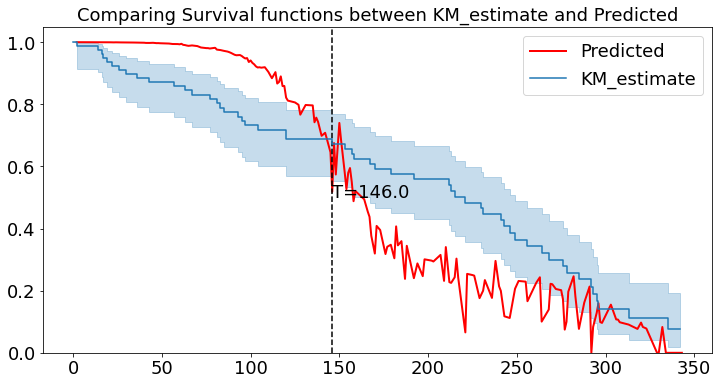

In [14]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [15]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=324, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [16]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [17]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [18]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'INBIRMO',
 'INBIRYR',
 'INSEX',
 'NACCNINR',
 'INRELTO',
 'INLIVWTH',
 'INVISITS',
 'INCALLS',
 'INRELY',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCFFTD',
 'ANYMEDS',
 'DRUG1',
 'NACCSTYR',
 'NACCTIYR',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'COMPORT',
 'CDRLANG',
 'NPIQINF',
 'DEL',
 'DELSEV',
 'HALL',
 'HALLSEV',
 'AGIT',
 'AGITSEV',
 'DEPD',
 'DEPDSEV',
 'ANX',
 'ANXSEV',
 'ELAT',
 'ELATSEV',
 'APA',
 'APASEV',
 'DISN',
 'DISNSEV',
 'IRR',
 'IRRSEV',
 'MOT',
 'MOTSEV',
 'NITE',
 'NITESEV',
 'APP',
 'APPSEV',
 'BILLS',
 'TAXES',
 'SHOPPING',
 'GAMES',
 'STOVE',
 'MEALPREP',
 'EVENTS',
 'PAYATTN',
 'REMDATES',
 'TRAVEL',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGFLUC',
 'COGOTHR',
 'NACCC

In [19]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [20]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[164,
 168,
 122,
 170,
 38,
 36,
 167,
 41,
 292,
 89,
 39,
 27,
 163,
 274,
 322,
 70,
 296,
 71,
 280,
 195,
 114,
 74,
 165,
 115,
 43,
 14,
 80,
 16,
 86,
 92,
 255,
 19,
 131,
 306,
 226,
 13,
 219,
 317,
 187,
 99,
 90,
 28,
 4,
 182,
 295,
 50,
 200,
 151,
 230,
 177,
 94,
 152,
 209,
 194,
 108,
 283,
 79,
 98,
 216,
 24,
 127,
 87,
 95,
 73,
 173,
 254,
 294,
 293,
 206,
 88,
 15,
 186,
 54,
 245,
 174,
 272,
 248,
 57,
 175,
 193,
 65,
 96,
 214,
 33,
 155,
 297,
 277,
 191,
 23,
 32,
 181,
 176,
 192,
 63,
 46,
 47,
 11,
 222,
 203,
 235]

In [21]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([14.19106  , 11.9310875, 11.414387 , 10.968302 , 10.863862 ,
       10.648941 , 10.548138 , 10.164744 ,  9.507485 ,  9.50273  ,
        9.439107 ,  9.419512 ,  9.400668 ,  9.338712 ,  9.281935 ,
        9.278534 ,  9.257485 ,  9.234996 ,  9.212389 ,  9.202654 ,
        9.1875925,  9.070295 ,  9.050494 ,  9.031195 ,  9.029467 ,
        9.028136 ,  9.013364 ,  9.006186 ,  8.983857 ,  8.981592 ,
        8.971183 ,  8.955682 ,  8.926913 ,  8.921    ,  8.91921  ,
        8.909078 ,  8.9032345,  8.899171 ,  8.886914 ,  8.876861 ,
        8.871779 ,  8.871076 ,  8.870577 ,  8.862546 ,  8.848769 ,
        8.845446 ,  8.844676 ,  8.8356085,  8.830272 ,  8.827201 ,
        8.825465 ,  8.810628 ,  8.80922  ,  8.800233 ,  8.78093  ,
        8.7807455,  8.780462 ,  8.767672 ,  8.767246 ,  8.758213 ,
        8.757873 ,  8.745967 ,  8.744704 ,  8.737238 ,  8.725812 ,
        8.722696 ,  8.71582  ,  8.71499  ,  8.710522 ,  8.703741 ,
        8.703173 ,  8.702026 ,  8.70198  ,  8.697795 ,  8.6959

In [22]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCAGE', 'NACCMCII', 'NACCAANX', 'COMMUN', 'ORIENT',
       'NACCIDEM', 'CDRSUM', 'NPTDPA', 'COGMODE', 'HOMEHOBB', 'NACCMOM',
       'NACCFTDM', 'NACCPICK', 'NACCDAGE', 'TAXES', 'NPTDPE', 'SHOPPING',
       'NPFTDT7', 'NPWBRWT', 'NACCPPA', 'MEALPREP', 'NACCNIHR',
       'NACCBVFT', 'CDRLANG', 'INDEPEND', 'DECIN', 'HANDED', 'COGFLUC',
       'BEDEP', 'NPWMR', 'INSEX', 'CORT', 'NPPDXJ', 'NPINF2B', 'NACCLIVS',
       'NACCAMY', 'NACCFORM', 'NACCNSD', 'BEPERCH', 'DECAGE', 'NACCDAD',
       'SEX', 'NACCDIUR', 'NPTDPD', 'AGITSEV', 'NPGRHA', 'DYSILL',
       'NPINF3B', 'NACCANGI', 'BEAHALL', 'DYSILLIF', 'NPHISG', 'NPFIX',
       'NACCMOTF', 'NPFTDT10', 'DECSUB', 'BEAGIT', 'NPADNC', 'INCALLS',
       'NACCLBDP', 'COGOTHR', 'BEDEL', 'STOVE', 'NACCADEP', 'NACCARTE',
       'NPTDPC', 'NPTDPB', 'NPASAN', 'NACCCOGF', 'RESIDENC', 'NACCLIPL',
       'ANXSEV', 'NPOLD3', 'NACCADMD', 'NPHIPSCL', 'NPOLDD', 'APA',
       'NACCAHTN', 'NPPMIH', 'NITE', 'BEDISIN', 'NACCBRAA', 'NACCSTYR',

In [23]:
np.array(column_names[:-2]).shape

(324,)

In [24]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [25]:
first_layer_weight.shape

(324, 150)

In [26]:
first_layer_weight

array([[ 0.03603799, -0.01384138, -0.00061959, ...,  0.02531353,
        -0.00013679, -0.0103498 ],
       [ 0.01856151,  0.01952776, -0.02041997, ...,  0.02507691,
        -0.00142851,  0.02493863],
       [-0.00580558,  0.02162408,  0.00966686, ..., -0.00819753,
         0.01920679, -0.03554213],
       ...,
       [ 0.01563221, -0.01588417,  0.02255794, ..., -0.00654055,
        -0.03371828, -0.00232372],
       [ 0.03619032,  0.01013045,  0.00936074, ..., -0.0239744 ,
         0.04088068,  0.00151824],
       [ 0.00351389, -0.01857186, -0.01697525, ...,  0.00620036,
        -0.02265813, -0.01490132]], dtype=float32)

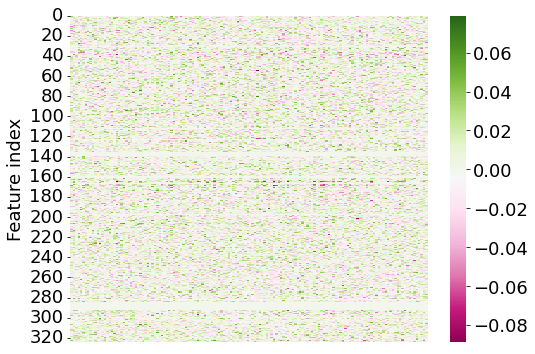

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

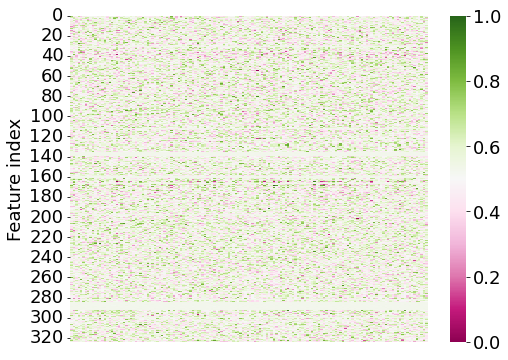

In [28]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()